In [57]:
%reload_ext autoreload
%autoreload 2

In [58]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [59]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [60]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

import numpy as np
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from spacy.lang.en import English
from spacy.pipeline.textcat import Config, single_label_cnn_config

from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [61]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            data=json.load(slack_data)
            combined.append(data)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and row['blocks'] is not None and len(row['blocks'][0]['elements'][0]['elements']) != 0:
                    msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users']))
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]
    dfall = dfall.reset_index(drop=True)

    return dfall

    # return dfall


def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            data = json.load(slack_data)
            combined.append(data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for slack_data in combined:
        # slack_data = json.load(open(k.name, 'r', encoding="utf-8"))

        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))

    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [62]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else:
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)

    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)

    return ac_comm_dict

In [63]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()
def get_bottom_10_user(data,channel):
    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def get_bottom_10_user_reaction(data,channel):
    data['user_id'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()


def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def plot_common_words(json_file_path, channel_name):
    # Read the JSON file
    with open(json_file_path, 'r', encoding="utf8") as json_file:
        data = json.load(json_file)

    # Convert the data to a DataFrame (adjust as per your JSON structure)
    df = pd.DataFrame(data)

    # Filter messages for the specified channel
    channel_data = df[df['channel'] == channel_name]

    # Combine the text of messages in the channel
    all_text = ' '.join([str(msg.get('text', '')) for msg in channel_data['topic']])

    # Split the text into words
    words = all_text.split()

    # Create a pandas Series for easy word counting
    word_counts = pd.Series(words).value_counts()

    # Plot the top N words
    top_n = 20  # Change this value to adjust the number of words to display
    plt.figure(figsize=(12, 6))
    word_counts.head(top_n).plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} Words in #{channel_name}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

#plot of top users with highest replies per message.
def plot_visualize_top_users_with_highest_reply_count(data: pd.DataFrame):
    grouped_df = data.groupby('sender_name')['reply_count'].sum()
    grouped_df = grouped_df.sort_values(ascending=False)
    grouped_df.plot(kind='bar', figsize=(15, 7.5))
    plt.yscale('log')
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of Replies')
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [64]:
def create_dataframe() -> pd.DataFrame:
    DIR = '../anonymized/'
    sl = SlackDataLoader(DIR)
    data_frames = [
        slack_parser(DIR + channel['name'] + '/')
        for channel in sl.get_channels()
    ]
    all_data = pd.concat(data_frames, ignore_index=True)
    return all_data

In [65]:
dframe = create_dataframe()
dframe

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,"a decent fellow, big ups brother",Gregory Bowman,1664960833.241189,text,1664954598.185699,0,0,0,0,
1,message,*community building session reminder!*:timer_c...,Lynn Shepherd,1664970601.066509,text,0,0,0,0,0,
2,message,when will we kahoot again:smirk:,Jennifer Carrillo,1664970669.636589,text,1664970669.636589,2,2,"U03V1AM5TFA,U03U1FNPEUX",1664970735.145469,
3,message,"soon very soon, you miss it hahahah",Lynn Shepherd,1664970705.135159,text,1664970669.636589,0,0,0,0,
4,message,yess,Jennifer Carrillo,1664970735.145469,text,1664970669.636589,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...
17744,message,how are we going to do the submission today? e...,Monica Newton,1667831518.280939,text,1667831518.280939,1,1,U03TEPYRM2P,1667831802.415459,
17745,message,thank you,Bridget Glover,1667831802.415459,text,1667831518.280939,0,0,0,0,
17746,message,"the document is not uploaded yet, and what is ...",Lisa Dickerson,1667833875.288709,text,1667833875.288709,2,1,U03UP7V9Q57,1667835382.576969,
17747,message,how can i get the trainees that opted-in a giv...,Dennis Parker,1668272023.894179,text,0,0,0,0,0,


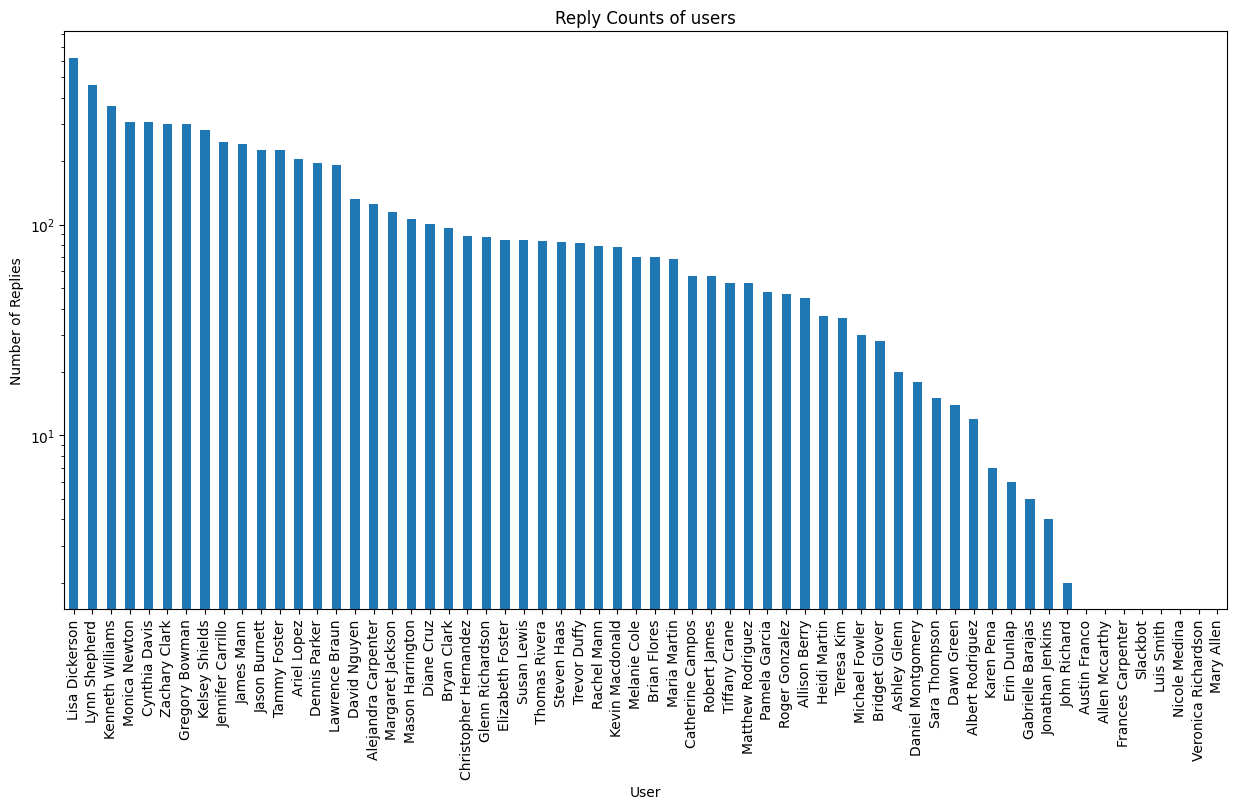

In [66]:
# Top 10 users with highest reply count
plot_visualize_top_users_with_highest_reply_count(dframe)

In [67]:
def get_top_users_by_replies_count(data: pd.DataFrame, top_n=10):
    top_users = data.nlargest(top_n, 'reply_count')[['sender_name', 'reply_count']]
    return top_users

In [68]:
#display users with highest replies
get_top_users_by_replies_count(dframe)

,sender_name,reply_count
7208,Kenneth Williams,75
975,Kevin Macdonald,63
15078,James Mann,61
1546,Kenneth Williams,57
10053,Bryan Clark,54
11662,Lynn Shepherd,45
16495,Jason Burnett,44
10141,Zachary Clark,36
11757,Lynn Shepherd,33
6843,Kenneth Williams,31


In [69]:
def get_bottom_users_by_replies_count(data: pd.DataFrame, bottom_n=10):
    bottom_users = data.nsmallest(bottom_n, 'reply_count')[['sender_name', 'reply_count']]
    return bottom_users

In [70]:
get_bottom_users_by_replies_count(dframe)

,sender_name,reply_count
0,Gregory Bowman,0
1,Lynn Shepherd,0
3,Lynn Shepherd,0
4,Jennifer Carrillo,0
6,Monica Newton,0
7,Daniel Montgomery,0
8,Trevor Duffy,0
9,Kenneth Williams,0
10,Thomas Rivera,0
11,Zachary Clark,0


In [71]:
#plot for top 10 users with reply count
def plot_top_users_with_highest_replies(data: pd.DataFrame, top_n=10):
    top_users = get_top_users_by_replies_count(data, top_n)

    plt.figure(figsize=(16, 8))
    plt.bar(top_users['sender_name'], top_users['reply_count'], color='pink')
    # plt.yscale('log')
    plt.title(f'Top {top_n} Users with the Highest Replies')
    plt.xlabel('User')
    plt.ylabel('Number of Replies')
    plt.show()

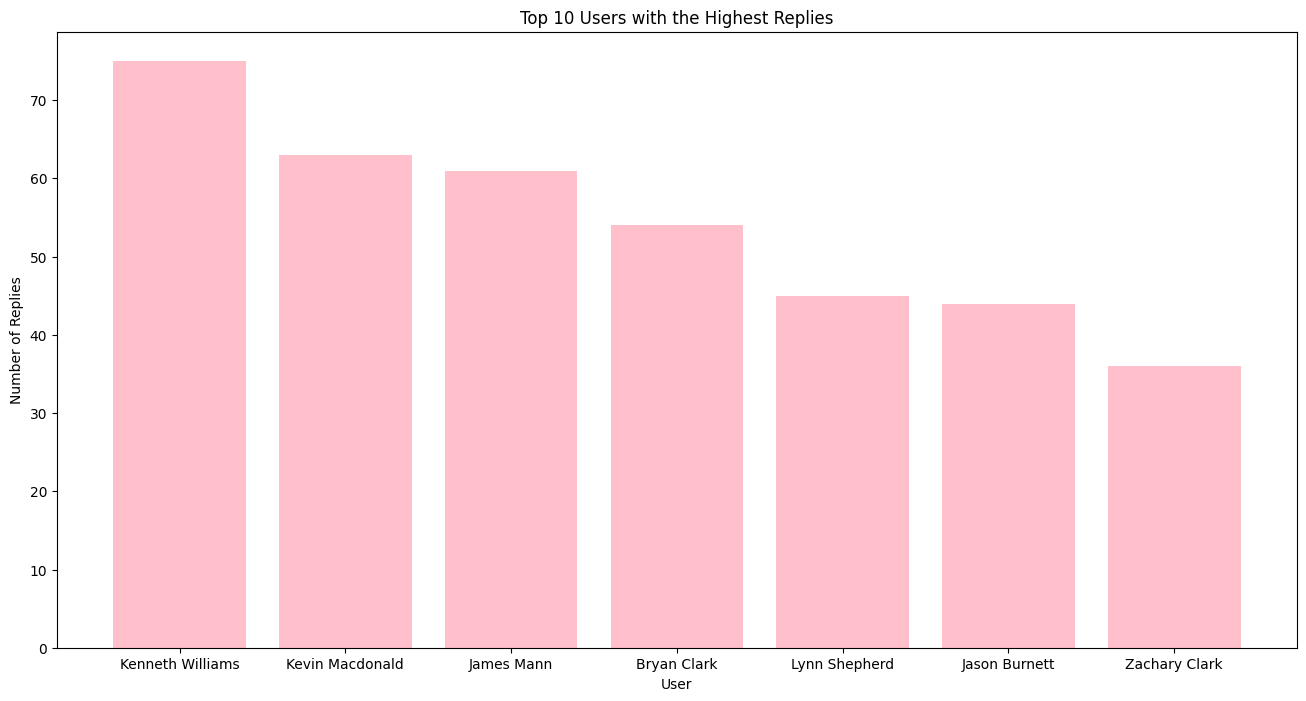

In [72]:
plot_top_users_with_highest_replies(dframe)

In [73]:
def plot_top_users_with_lowest_replies(data: pd.DataFrame, top_n=10):
    bottom_users = get_bottom_users_by_replies_count(data, top_n)

    plt.figure(figsize=(12, 6))
    plt.scatter(bottom_users['sender_name'], bottom_users['reply_count'], color='pink', s=100)
    plt.title(f'Top {top_n} Users with the Lowest Replies')
    plt.xlabel('User')
    plt.ylabel('Number of Replies')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def get_bottom_users_by_replies_count(data: pd.DataFrame, top_n=10):
    return data.nsmallest(top_n, 'reply_count')[['sender_name', 'reply_count']]

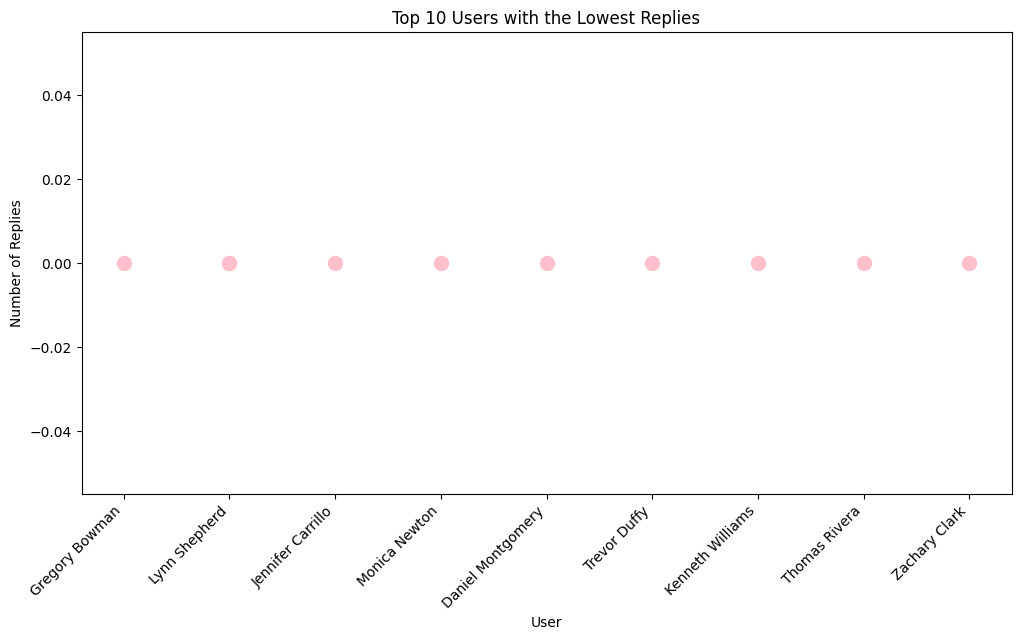

In [74]:
plot_top_users_with_lowest_replies(dframe)

In [75]:
# get 10 top users based on message count
def get_top_users_by_message_count(data: pd.DataFrame, top_n=10):
    user_counts = data.groupby('sender_name').size()
    top_users = user_counts.nlargest(top_n).reset_index(name='message_count')
    return top_users

In [76]:
get_top_users_by_message_count(dframe)

,sender_name,message_count
0,Lynn Shepherd,1288
1,Kelsey Shields,1150
2,Gregory Bowman,1075
3,Zachary Clark,991
4,Monica Newton,843
5,Lisa Dickerson,831
6,Ariel Lopez,754
7,James Mann,641
8,Tammy Foster,574
9,Jennifer Carrillo,519


In [77]:
def plot_top_users_with_message_counts(data: pd.DataFrame, top_n=10):
    top_users = get_top_users_by_message_count(data)
    plt.figure(figsize=(16, 8))
    plt.bar(top_users['sender_name'], top_users['message_count'], color='pink')
    plt.title(f'Top {top_n} Users with the Message Count')
    plt.xlabel('User')
    plt.ylabel('Number of Message Count')
    plt.show()

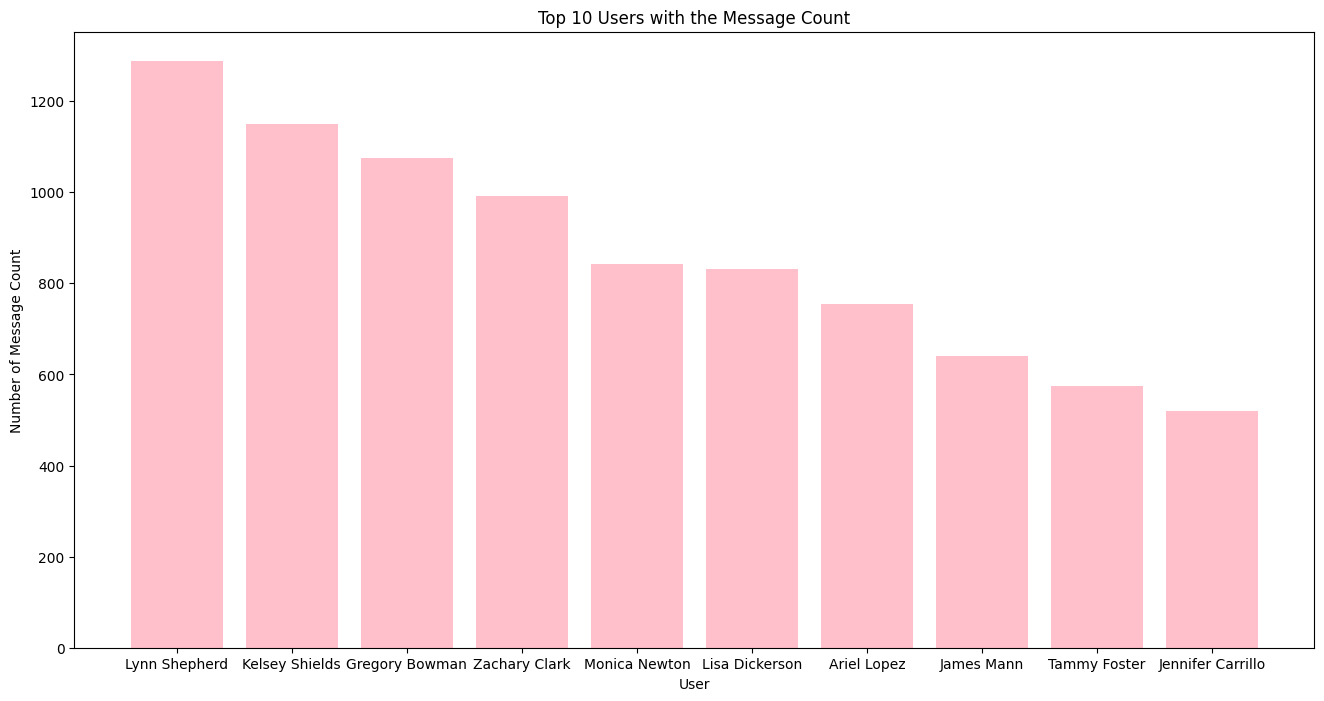

In [78]:
plot_top_users_with_message_counts(dframe)

In [79]:
# get 10 bottom users based on message count
def get_bottom_users_by_message_count(data: pd.DataFrame, top_n=10):
    user_counts = data.groupby('sender_name').size()
    bottom_users = user_counts.nsmallest(top_n).reset_index(name='message_count')
    return bottom_users

In [80]:
get_bottom_users_by_message_count(dframe)

,sender_name,message_count
0,Allen Mccarthy,1
1,Austin Franco,1
2,Mary Allen,1
3,Nicole Medina,1
4,Veronica Richardson,1
5,Slackbot,3
6,Frances Carpenter,5
7,Jonathan Jenkins,7
8,Luis Smith,8
9,John Richard,10


In [81]:
def plot_top_users_with_lowest_message_count(data: pd.DataFrame, top_n=10):
    bottom_users = get_bottom_users_by_message_count(data, top_n)

    plt.figure(figsize=(12, 6))
    plt.scatter(bottom_users['sender_name'], bottom_users['message_count'], color='pink', s=100)
    plt.title(f'Top {top_n} Users with the Lowest Message count')
    plt.xlabel('User')
    plt.ylabel('Number of Message Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

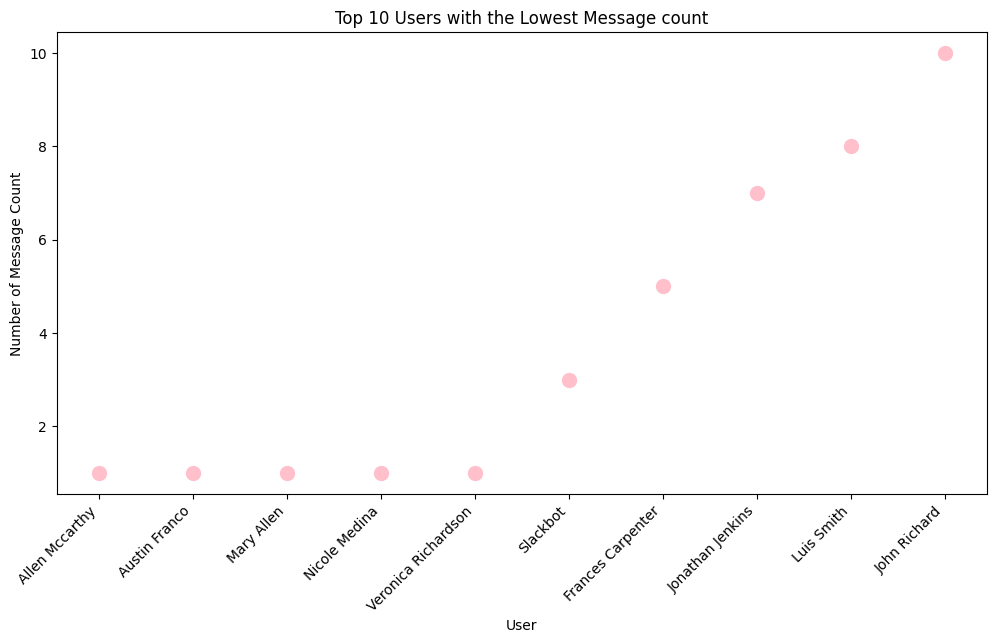

In [82]:
plot_top_users_with_lowest_message_count(dframe)

In [83]:
parse_slack_reaction('../anonymized/all-community-building/', 'all-community-building')

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,+1::skin-tone-3,1,U03U9EJR362,*hot seat announcement!* <!here>\n_*good morni...,U03V1AM5TFA,all-community-building
1,+1,2,"U03UG5VFN03,U03UVHCV6KB",*hot seat announcement!* <!here>\n_*good morni...,U03V1AM5TFA,all-community-building
2,pray,1,U03UG5VFN03,*hot seat announcement!* <!here>\n_*good morni...,U03V1AM5TFA,all-community-building
3,innocent,1,U03UHB8CXDY,"a decent fellow, big ups brother",U03UVHCV6KB,all-community-building
4,joy,1,U03U1J51VFZ,i can laugh non stop like mr girma belachew. w...,U03UG32J3PC,all-community-building
...,...,...,...,...,...,...
3186,new_moon_with_face,1,U03V6HMRPGQ,"fun fact tho, i don't drink coffee",U03UJGP0C68,all-community-building
3187,smiley,1,U03U1FNPEUX,"i missed cbs, it was lit damn",U03UJGP0C68,all-community-building
3188,raised_hands,1,U03UJGP0C68,good for you bro. that's really good. jegna,U03UG32J3PC,all-community-building
3189,handshake,2,"U03UG32J3PC,U03V6HMRPGQ",:handshake: <@u03ug32j3pc> we're buddies at le...,U03UD68RQH3,all-community-building


In [84]:
ROOT_DIR = '../anonymized/'
sl = SlackDataLoader(ROOT_DIR)
sl.get_users()
users_map = sl.get_user_map()[0]
user_names_df = pd.DataFrame({
    'user_id' : list(users_map.keys()),
    'user_name': list(users_map.values())
})


In [85]:
# data frame for reaction
def create_reaction_data_frame():
    DIR = '../anonymized/'
    sl = SlackDataLoader(DIR)
    channels = sl.get_channels()
    channel_names = [channels[i]['name'] for i in range(len(channels))]
    reaction_data_frames = []

    for name in channel_names:
        channel_path = DIR + name + '/'
        channel_dataframe = parse_slack_reaction(channel_path, name)
        reaction_data_frames.append(channel_dataframe)

    all_data = pd.concat(reaction_data_frames, ignore_index=True)
    return all_data

In [86]:
dframe_rection = create_reaction_data_frame()
dframe_rection

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,+1::skin-tone-3,1,U03U9EJR362,*hot seat announcement!* <!here>\n_*good morni...,U03V1AM5TFA,all-community-building
1,+1,2,"U03UG5VFN03,U03UVHCV6KB",*hot seat announcement!* <!here>\n_*good morni...,U03V1AM5TFA,all-community-building
2,pray,1,U03UG5VFN03,*hot seat announcement!* <!here>\n_*good morni...,U03V1AM5TFA,all-community-building
3,innocent,1,U03UHB8CXDY,"a decent fellow, big ups brother",U03UVHCV6KB,all-community-building
4,joy,1,U03U1J51VFZ,i can laugh non stop like mr girma belachew. w...,U03UG32J3PC,all-community-building
...,...,...,...,...,...,...
5012,raised_hands,1,U03UG5VFN03,etl and elt,U03UHB8CXDY,all-week12
5013,white_check_mark,1,U03UJGP0C68,please use the submission link for week 12 to ...,U03TEPYRM2P,all-week12
5014,eyes,2,"U03UG1Z21JP,U03U1HAG9TR",what are we submitting today?,U03V785NLSU,all-week12
5015,white_check_mark,3,"U03V6HMRPGQ,U03UG5VFN03,U03UHB8CXDY",the document will be shared soon.\n\nfor the s...,U03UP7V9Q57,all-week12


In [87]:
def users_with_highest_reactions(data: pd.DataFrame):
    users = data.sort_values(by='reaction_count', ascending=False).head(10)
    users_reactions = users[['user_id', 'reaction_count']]
    merged = users_reactions.merge(user_names_df, on='user_id',how='inner')
    return merged[['user_name', 'reaction_count']]

In [88]:
users_with_highest_reactions(dframe_rection)

,user_name,reaction_count
0,Bridget,17
1,Bridget,15
2,Robert,16
3,Daniel,16
4,Lawrence,16
5,Lynn,15
6,Lynn,15
7,Lisa,14
8,Brian,14
9,Tiffany,13


In [89]:
def plot_top_users_with_reaction_counts(data: pd.DataFrame, top_n=10):
    top_users = users_with_highest_reactions(data)
    plt.figure(figsize=(12, 6))
    plt.scatter(bottom_users['sender_name'], top_users['message_count'], color='pink', s=100)
    plt.title(f'Top {top_n} Users with the Lowest Message count')
    plt.xlabel('User')
    plt.ylabel('Number of Message Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [90]:
# plot_top_users_with_m_counts(dframe_rection)

In [91]:
def users_with_lowest_reactions(data: pd.DataFrame):
    users = data.sort_values(by='reaction_count', ascending=True).head(10)
    users_reactions = users[['user_id', 'reaction_count']]
    merged = users_reactions.merge(user_names_df, on='user_id',how='inner')
    return merged[['user_name', 'reaction_count']]

In [92]:
users_with_lowest_reactions(dframe_rection)

,user_name,reaction_count
0,Lynn,1
1,Daniel,1
2,Daniel,1
3,Thomas,1
4,Thomas,1
5,Mason,1
6,Mason,1
7,Glenn,1
8,Zachary,1
9,Zachary,1


In [93]:
def plot_bottom_users_with_reaction_counts(data: pd.DataFrame, top_n=10):
    bottom_users = users_with_lowest_reactions(data)
    plt.figure(figsize=(12, 6))
    plt.scatter(bottom_users['user_name'], bottom_users['reaction_count'], color='pink', s=100)
    plt.title(f'Top {top_n} Users with the Lowest Message count')
    plt.xlabel('User')
    plt.ylabel('Number of Message Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

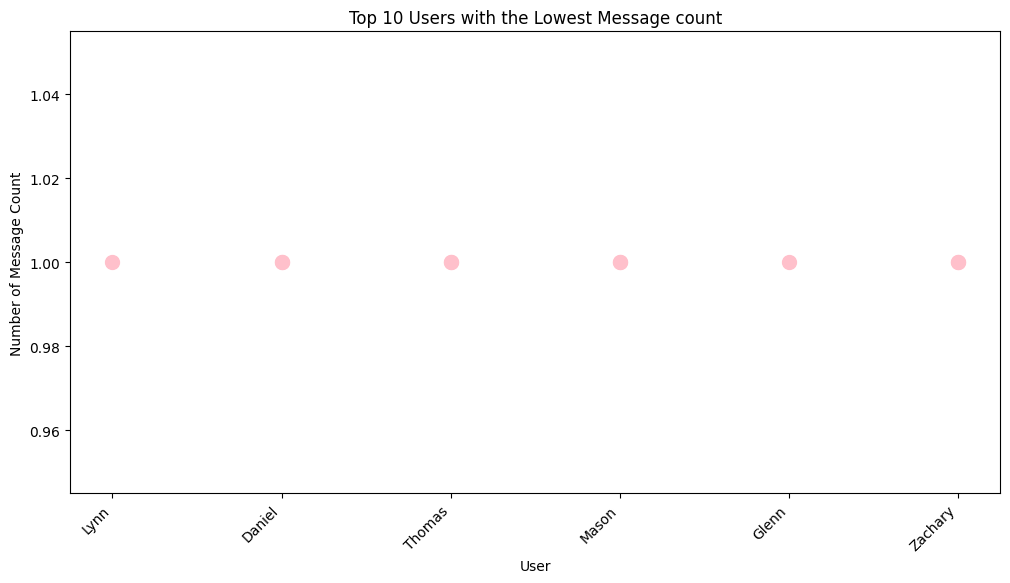

In [94]:
plot_bottom_users_with_reaction_counts(dframe_rection)

In [95]:
def message_with_replies(data: pd.DataFrame):
    df = data.sort_values(by='reply_count', ascending=False)
    return df

In [96]:
#message with top replies
messages = message_with_replies(dframe)
messages.head(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
7208,message,<@u03v1am5tfa> how many crushes you have?,Kenneth Williams,1668169350.223689,user,1668169350.223689,75,8,"U03V1AM5TFA,U03UUS0MZCZ,U03UG32J3PC,U03UVHCV6K...",1668173595.550369,
975,message,first impression: people think i am older than...,Kevin Macdonald,1663072090.617319,text,1663072090.617319,63,8,"U03UUR571A5,U03UG32J3PC,U03UFV7TUTV,U03V785NLS...",1663077515.282329,
15078,message,1. how do i find my jupyter notebook file in m...,James Mann,1664916746.043439,rich_text_section,1664916746.043439,61,5,"U03UUR571A5,U03UVHCV6KB,U03U9EJR362,U03UD68RQH...",1664920378.724399,
1546,message,how many here follow football so much? i think...,Kenneth Williams,1666700374.650289,text,1666700374.650289,57,10,"U03V5Q9N516,U03V785NLSU,U03UG32J3PC,U03UJN29Y4...",1666709362.373899,
10053,message,ethiopian new year loading ....,Bryan Clark,1662400744.293029,text,1662400744.293029,54,3,"U03UG32J3PC,U03UUR571A5,U03UFV7TUTV",1662406508.168569,
11662,message,hello\n1. <@u03uvhcv6kb>\n2. <@u03ug5vfn03>\n3...,Lynn Shepherd,1667286619.471889,text,1667286619.471889,45,7,"U03UG32J3PC,U03UG0SFHGT,U03UG5VFN03,U03V1AM5TF...",1667308401.183059,
16495,message,<@u03uur571a5> solutions to funding account an...,Jason Burnett,1666858629.076399,user,1666858629.076399,44,4,"U03UUR571A5,U03UJGP0C68,U03U1FNPEUX,U03UKL27B0R",1666944753.417749,
10141,message,we had a plan to meet today 2:00 eat at friend...,Zachary Clark,1667700160.574059,text,1667700160.574059,36,4,"U03UG32J3PC,U03UUR571A5,U03UD68RQH3,U03UG0YHAUT",1667713572.552719,
11757,message,*<!here> reminder*:timer_clock:\n\n*please not...,Lynn Shepherd,1665137100.215739,broadcast,1665137100.215739,33,3,"U03UH397319,U03TEPYRM2P,U03V1AM5TFA",1665142057.729989,
6843,message,"the debate was great. we <@u03u1j51vfz>, <@u03...",Kenneth Williams,1665057691.571429,text,1665057691.571429,31,12,"U03UUR571A5,U03U1J51VFZ,U03UD68RQH3,U03UJN29Y4...",1665059196.765399,


In [97]:
#messages with low replies
messages.tail(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
6286,message,i knew Lynn would gloat on my absence.:rolling...,Ariel Lopez,1667223458.795429,text,1667219058.497169,0,0,0,0,
6287,message,"<@u03ujkjgraq> what exactly will you miss, don...",Lynn Shepherd,1667224541.153779,user,1667218895.649919,0,0,0,0,
6288,message,".. i will miss everything, particularly the fu...",Kenneth Williams,1667224846.565619,text,1667218895.649919,0,0,0,0,
6289,message,physically yes but mentally is the reverse one...,Steven Haas,1667226264.158849,text,0,0,0,0,0,
6290,message,aaaa <@u03v1am5tfa> sorry man. but for sure i'...,Pamela Garcia,1667227856.149669,text,1667219340.307769,0,0,0,0,
6292,message,adult or kid's toy?,Cynthia Davis,1667279705.726879,text,1667250876.632019,0,0,0,0,
6293,message,everyone’s,Jennifer Carrillo,1667280893.982019,text,1667250876.632019,0,0,0,0,
6294,message,"hmmm, that i dont know",Cynthia Davis,1667281453.783909,text,1667250876.632019,0,0,0,0,
6295,message,<https://www.genardmethod.com/blog/bid/80384/h...,Gregory Bowman,1667283861.061099,link,0,0,0,0,0,
17748,message,<https://developer.algorand.org/solutions/mint...,Dennis Parker,1668359175.400459,link,0,0,0,0,0,


In [98]:
def messages_with_reactions(data: pd.DataFrame):
    return data.sort_values(by='reaction_count', ascending=False)

In [99]:
messages = messages_with_reactions(dframe_rection)

In [100]:
messages.head(10)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
4695,white_check_mark,17,"U03UG5VFN03,U03UJGP0C68,U03V785NLSU,U03UG0YHAU...","good morning winners, welcome to week 9 of wee...",U03TEPYRM2P,all-week9
2138,joy,16,"U03UUR571A5,U03V785NLSU,U03UD68RQH3,U03UD4FEDH...",my reactions when am not finished the task bef...,U03UG0SFHGT,all-community-building
249,raised_hands,16,"U03UD68RQH3,U03U9EJR362,U03UFV7TUTV,U03U1FNPEU...",,U03U1GHT39V,all-community-building
4085,raised_hands,16,"U03U1GHT39V,U03UJN29Y4C,U03UG1RTXAP,U03UG4Q7V4...",little known fact - all Joanne academy technic...,U03U93GNNVB,all-broadcast
1322,rolling_on_the_floor_laughing,15,"U03UG32J3PC,U03U9EJR362,U03U1HAG9TR,U03UJGP0C6...",*guys <!here>.... make sure to come back from ...,U03V1AM5TFA,all-community-building
4468,raised_hands,15,"U03UG32J3PC,U03V61VGQG0,U03UG0YHAUT,U03UJGRN5E...","welcome to week6 everyone. by friday, we’ll be...",U03TEPYRM2P,all-week6
1444,joy,15,"U03V6HMRPGQ,U03U9EJR362,U03UFV7HFNF,U03UVHCV6K...",*here are some other stories from people that ...,U03V1AM5TFA,all-community-building
1404,rolling_on_the_floor_laughing,14,"U03UJGP0C68,U03UG4Q7V42,U03UFV7HFNF,U03UG1Z21J...","1- let me open my vpn, where do you want me to...",U03V6HMRPGQ,all-community-building
3245,raised_hands,14,"U03UJGP0C68,U03UG32J3PC,U03UG0SFHGT,U03UG1Z21J...",<!channel>\nthere will be no careers exercise ...,U03TT5KEYCF,all-career-exercises
1640,joy,13,"U03UJKJGRAQ,U03UD68RQH3,U03U1HAG9TR,U03UG4Q7V4...",3 things i dont want him to know:\n\n1. that i...,U03UG1Z21JP,all-community-building


In [101]:
#message with lowest reactions
messages.tail(10)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
2182,rolling_on_the_floor_laughing,1,U03UJGP0C68,<@u03uur571a5> :rolling_on_the_floor_laughing:...,U03UG4Q7V42,all-community-building
2183,rolling_on_the_floor_laughing,1,U03UG32J3PC,do you remember the one who completes this ser...,U03UG0YHAUT,all-community-building
2186,joy,1,U03UG1Z21JP,"yeah <@u03uvhcv6kb>, one day when i was coming...",U03UG0YHAUT,all-community-building
2188,raised_hands,1,U03UG0YHAUT,the tings i would give to go back !!,U03UVHCV6KB,all-community-building
2190,raised_hands::skin-tone-3,1,U03U9EJR362,lets use week 8 groups,U03V1AM5TFA,all-community-building
2193,raised_hands::skin-tone-3,1,U03U9EJR362,on behalf of group 1:\n1. communication \n2. c...,U03UJKJGRAQ,all-community-building
2194,raised_hands::skin-tone-4,1,U03UG4Q7V42,on behalf of group 1:\n1. communication \n2. c...,U03UJKJGRAQ,all-community-building
2196,white_check_mark,1,U03U1FNPEUX,group 4:\nJoanne life lessons in Joanne weeks\...,U03UG0YHAUT,all-community-building
2197,raised_hands::skin-tone-4,1,U03UG4Q7V42,group 4:\nJoanne life lessons in Joanne weeks\...,U03UG0YHAUT,all-community-building
5016,raised_hands,1,U03UVHCV6KB,<@u03ul5lstg9> has joined the channel,U03UL5LSTG9,data-engineering


In [102]:
# def difference_between_consecutive_messages(data: pd.DataFrame):
#     pd = data
#     print(pd)
#     pd.sort_values(by='msg_sent_time', ascending=False)
#     pd['time_sent'] = utils.convert_2_timestamp('msg_sent_time', data)
#     pd['time_difference_minutes'] = pd['time_sent'].diff().dt.total_seconds() / 60

#     plt.hist(pd['time_difference_minutes'].dropna(), bins=20, edgecolor='black')
#     plt.xlabel('Time Difference (in minutes)')
#     plt.ylabel('Frequency')
#     plt.title('Distribution of Time Differences')
#     plt.show()
#     return pd

In [103]:
# difference_between_consecutive_messages(dframe)

In [104]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [105]:
data = dframe['msg_content'].values.tolist()

data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub(r'\s+', ' ', sent) for sent in data]
data = [re.sub(r"\'", "", sent) for sent in data]
data = [re.sub(r"@U\w+", "", sent) for sent in data]

In [106]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['decent', 'fellow', 'big', 'ups', 'brother']]


In [107]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[data_words[0]]])

['decent', 'fellow', 'big', 'ups', 'brother']


In [108]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [109]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['decent', 'fellow', 'big', 'up', 'brother']]


In [110]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1)], [], [(12, 1), (13, 1), (14, 2)], [(15, 1)], [(16, 1), (17, 1)], [(18, 1)], [], [], [(19, 1)], [], [], [], [], [], [(19, 1)], [], [(20, 1)], [(19, 1)], [], [], [(6, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)], [(19, 1)], [(29, 1)], [(30, 1)], [(6, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)], [(28, 1), (30, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)], [(25, 1)], [], [(41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [(41, 1), (47, 1)], [(6, 1), (36, 1), (46, 1), (48, 1), (49, 1), (50, 1)], [(48, 1), (51, 1)], [(52, 1), (53, 1)], [(54, 1)], [(29, 1), (36, 1), (55, 1), (56, 1)], [(6, 1), (28, 1), (39, 1), (40, 1), (57, 1), (58, 1)], [(14, 1)], [(30, 1)], [(36, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(63, 1), (64, 1)], [(0, 1), (22, 1), (25, 1), (26, 1), (28, 1), (37, 1), (65, 1), (66, 1), (67, 1), (68, 1)], [(52, 1), (59, 1), (60, 1)], [(36

In [111]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [112]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.293*"know" + 0.108*"miss" + 0.092*"soon" + 0.000*"celebrate" + '
  '0.000*"let" + 0.000*"logo" + 0.000*"try" + 0.000*"work" + 0.000*"datum" + '
  '0.000*"possible"'),
 (1,
  '0.000*"configure" + 0.000*"iterative" + 0.000*"onboarde" + '
  '0.000*"utm_campaign" + 0.000*"token" + 0.000*"frhqfhm" + 0.000*"opt" + '
  '0.000*"pytorch" + 0.000*"emnlp" + 0.000*"hyperparameter"'),
 (2,
  '0.253*"today" + 0.236*"need" + 0.202*"self" + 0.040*"ready" + 0.030*"hear" '
  '+ 0.002*"life" + 0.000*"python_site" + 0.000*"jds_document" + '
  '0.000*"file_home" + 0.000*"py_line"'),
 (3,
  '0.449*"com" + 0.220*"m" + 0.046*"keep" + 0.041*"youtube" + 0.024*"watch" + '
  '0.009*"big" + 0.002*"brother" + 0.000*"https" + 0.000*"work" + '
  '0.000*"linkedin"'),
 (4,
  '0.163*"grin" + 0.099*"wrong" + 0.021*"family" + 0.000*"finally" + '
  '0.000*"good" + 0.000*"use" + 0.000*"issue" + 0.000*"chaiotic" + '
  '0.000*"blush" + 0.000*"turn"'),
 (5,
  '0.280*"guy" + 0.253*"sure" + 0.171*"meeting" + 0.063*"cal

In [113]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.111207 -0.022548       1        1  14.784304
13     0.199412 -0.247749       2        1  13.882626
9      0.239884  0.304870       3        1  10.514110
17     0.172397 -0.086329       4        1  10.174459
10     0.040262 -0.003277       5        1   9.244738
2      0.058414 -0.006557       6        1   6.928951
5      0.076625 -0.010693       7        1   4.982734
12    -0.046228  0.005318       8        1   4.858878
18    -0.055813  0.005782       9        1   4.000635
7     -0.067959  0.006242      10        1   3.780261
0     -0.076822  0.006339      11        1   3.623954
15    -0.042808  0.005133      12        1   3.616312
16    -0.061147  0.006012      13        1   2.528088
4     -0.082768  0.005702      14        1   1.897820
11    -0.074989  0.006343      15        1   1.699629
6     -0.079172  0.006301      16        1   1.428824
14    -0.082949  0.005836      17        1   1.076100
8     -0.075902  0.004432      18        1   0.365628
19    -0.075822  0.004421      19        1   0.306762
1     -0.075822  0.004421      20        1   0.305186, topic_info=          Term         Freq        Total Category  logprob  loglift
247        com  5479.000000  5479.000000  Default  30.0000  30.0000
28       think  3343.000000  3343.000000  Default  29.0000  29.0000
66         get  3106.000000  3106.000000  Default  28.0000  28.0000
426       meet  3101.000000  3101.000000  Default  27.0000  27.0000
11        time  2924.000000  2924.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
25        long     0.032791   322.580277  Topic20  -8.9461  -3.4019
26    remember     0.032791   250.182840  Topic20  -8.9461  -3.1478
27   situation     0.032791     3.019619  Topic20  -8.9461   1.2693
28       think     0.032791  3343.567986  Topic20  -8.9461  -5.7404
29      second     0.032791   134.386084  Topic20  -8.9461  -2.5263

[907 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
126       5  0.969780    afraid
65        3  0.997838      also
96        5  0.985379    answer
0         1  0.971940       big
16       12  0.263556  birthday
...     ...       ...       ...
68        9  0.995613       way
56       12  0.996001      well
145      13  0.991250     write
137      14  0.979427     wrong
690       1  0.994424   youtube

[95 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 14, 10, 18, 11, 3, 6, 13, 19, 8, 1, 16, 17, 5, 12, 7, 15, 9, 20, 2])

In [116]:
#Sentiment Analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/azizamed/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [119]:
df = dframe
df['day'] = convert_2_timestamp('msg_sent_time', df)
df['day'] = pd.to_datetime(df['day']).dt.date
grouped_df = df.groupby('day')

result_df = grouped_df.agg({'msg_content': ' '.join}).reset_index()
result_df

,day,msg_content
0,2022-08-20,i am glad to make it to the week 1-4 program. ...
1,2022-08-21,"hi all, looking forward to starting together, ..."
2,2022-08-22,*community building session reminder!*:timer_c...
3,2022-08-23,finally i cant wait are you guys readyyyyyyyyy...
4,2022-08-24,<@u03t89acuuw> i can not join standup. i have ...
...,...,...
96,2022-11-26,<https://youtu.be/-dvyjdw4t9i|https://youtu.be...
97,2022-11-27,<https://resources.biginterview.com/interview-...
98,2022-11-30,"hey <!channel>, can everyone work on deploymen..."
99,2022-12-12,"<!channel> hi all, this version of slack will ..."


In [120]:
#run the polairty score
res = {}
for index, row in result_df.iterrows():
    msg_content = row['msg_content']
    day = row['day']
    res[day] = sia.polarity_scores(msg_content)

res_df = pd.DataFrame(res).T
res_df = res_df.reset_index().rename(columns={'index': 'day'})
res_df

,day,neg,neu,pos,compound
0,2022-08-20,0.000,0.622,0.378,0.9902
1,2022-08-21,0.000,0.748,0.252,0.9634
2,2022-08-22,0.057,0.781,0.162,0.9998
3,2022-08-23,0.050,0.777,0.173,1.0000
4,2022-08-24,0.035,0.772,0.193,1.0000
...,...,...,...,...,...
96,2022-11-26,0.000,0.735,0.265,0.9200
97,2022-11-27,0.000,1.000,0.000,0.0000
98,2022-11-30,0.000,0.918,0.082,0.3802
99,2022-12-12,0.000,0.676,0.324,0.8439


In [121]:
sementical_result = res_df.merge(result_df, how='left', on='day')
sementical_result

,day,neg,neu,pos,compound,msg_content
0,2022-08-20,0.000,0.622,0.378,0.9902,i am glad to make it to the week 1-4 program. ...
1,2022-08-21,0.000,0.748,0.252,0.9634,"hi all, looking forward to starting together, ..."
2,2022-08-22,0.057,0.781,0.162,0.9998,*community building session reminder!*:timer_c...
3,2022-08-23,0.050,0.777,0.173,1.0000,finally i cant wait are you guys readyyyyyyyyy...
4,2022-08-24,0.035,0.772,0.193,1.0000,<@u03t89acuuw> i can not join standup. i have ...
...,...,...,...,...,...,...
96,2022-11-26,0.000,0.735,0.265,0.9200,<https://youtu.be/-dvyjdw4t9i|https://youtu.be...
97,2022-11-27,0.000,1.000,0.000,0.0000,<https://resources.biginterview.com/interview-...
98,2022-11-30,0.000,0.918,0.082,0.3802,"hey <!channel>, can everyone work on deploymen..."
99,2022-12-12,0.000,0.676,0.324,0.8439,"<!channel> hi all, this version of slack will ..."


In [ ]:
sementical_result.df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('sementical Analysis by Day')
plt.xlabel('Day')
plt.ylabel('Sentiment Score')
plt.show()